# Basic information

## three fanspages
* imeifoods id='202586376996' 
* iLoveKCmilk id='180080052032125' 
* Dominos.tw id='115361891807579'

In [1]:
import pyes
import json
from IPython.core.display import display, HTML


host = '192.168.1.100:9200'
conn = pyes.es.ES(host)

fnames = ['imeifoods', 'iLoveKCmilk', 'Dominos.tw']
fids = ['202586376996', '180080052032125', '115361891807579']

tqs = [pyes.query.TermQuery(field="fid", value=fid) for fid in fids]
rs = [conn.search(query=tq, indices='facebook_nested', doc_types='fanpage') for tq in tqs]

print 'I choose three fanpages to analyze as following'
for r, name in zip(rs, fnames):
    display(HTML('<a href='+ json.dumps(r[0]['link'], indent=2) + ' target="_blank">' + name + '</a>'))

I choose three fanpages to analyze as following


## searching range (2015 whole year)

In [2]:
ESR = pyes.ESRange(field='created_time', from_value='2015-01-02T00:00:00+0800', to_value='2015-12-31T23:59:59+0800', 
                   include_lower=True, include_upper=False) # use whole data in 2015
rq = pyes.query.RangeQuery(qrange=ESR)
bqs = [pyes.query.BoolQuery().add_must(rq).add_must(tq) for tq in tqs]

## # of comments

In [3]:
res = [conn.search(query=bq, indices='facebook_nested', doc_types='comment') for bq in bqs]
print [len(r) for r in res]

[25541, 15183, 35130]


## # of posts

In [4]:
res = [conn.search(query=bq, indices='facebook_nested', doc_types='post') for bq in bqs]
print [len(r) for r in res]

[207, 104, 364]


## aggregate by 12 months

In [5]:
DHAgg = pyes.aggs.DateHistogramAgg('month', field='created_time', interval='month')

qs = [pyes.query.Search(bq) for bq in bqs]
for q in qs:
    q.agg.add(DHAgg)

## # of comments in 12 months

In [6]:
rs = [conn.search(query=q, indices='facebook_nested', doc_types='comment') for q in qs]
comment_month = [[rs[i].aggs['month']['buckets'][m]['doc_count'] for m in range(12)] for i in range(3)]
print comment_month

[[654, 903, 5042, 1150, 1461, 1821, 5581, 480, 1149, 2685, 2560, 2055], [5747, 1237, 2, 609, 2385, 2524, 339, 169, 464, 1535, 22, 150], [1296, 679, 1797, 964, 2762, 1655, 2388, 4970, 4386, 3053, 5659, 5521]]


## # of posts in 12 months

In [7]:
rs = [conn.search(query=q, indices='facebook_nested', doc_types='post') for q in qs]
post_month = [[rs[i].aggs['month']['buckets'][m]['doc_count'] for m in range(12)] for i in range(3)]
print post_month

[[16, 15, 15, 12, 14, 15, 28, 14, 17, 22, 15, 24], [17, 8, 0, 9, 10, 13, 11, 10, 8, 12, 1, 5], [40, 25, 26, 38, 32, 33, 35, 29, 25, 26, 30, 25]]


# Visualization: use Bokeh

In [8]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

## bar charts: imeifoods

In [11]:
from bokeh.charts import Bar
from bokeh.charts.attributes import CatAttr

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

comment_dict = dict(data=comment_month[0], label=MONTHS)
post_dict = dict(data=post_month[0], label=MONTHS)

comment_bar = Bar(comment_dict, values='data', label=CatAttr(columns=['label'], sort=False), 
               plot_width=450, plot_height=450, legend=None, title='Comments count')
post_bar = Bar(post_dict, values='data', label=CatAttr(columns=['label'], sort=False), 
             plot_width=450, plot_height=450, legend=None, title='Posts count')

comment_bar.xaxis.axis_label = post_bar.xaxis.axis_label = ''
comment_bar.yaxis.axis_label = 'comments'
post_bar.yaxis.axis_label = 'posts'

show(row(comment_bar, post_bar))

## bar charts: iLoveKCmilk

In [12]:
from bokeh.charts import Bar
from bokeh.charts.attributes import CatAttr

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

comment_dict = dict(data=comment_month[1], label=MONTHS)
post_dict = dict(data=post_month[1], label=MONTHS)

comment_bar = Bar(comment_dict, values='data', label=CatAttr(columns=['label'], sort=False), 
               plot_width=450, plot_height=450, legend=None, title='Comments count')
post_bar = Bar(post_dict, values='data', label=CatAttr(columns=['label'], sort=False), 
             plot_width=450, plot_height=450, legend=None, title='Posts count')

comment_bar.xaxis.axis_label = post_bar.xaxis.axis_label = ''
comment_bar.yaxis.axis_label = 'comments'
post_bar.yaxis.axis_label = 'posts'

show(row(comment_bar, post_bar))

## bar charts: Dominos.tw

In [13]:
from bokeh.charts import Bar
from bokeh.charts.attributes import CatAttr

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

comment_dict = dict(data=comment_month[2], label=MONTHS)
post_dict = dict(data=post_month[2], label=MONTHS)

comment_bar = Bar(comment_dict, values='data', label=CatAttr(columns=['label'], sort=False), 
               plot_width=450, plot_height=450, legend=None, title='Comments count')
post_bar = Bar(post_dict, values='data', label=CatAttr(columns=['label'], sort=False), 
             plot_width=450, plot_height=450, legend=None, title='Posts count')

comment_bar.xaxis.axis_label = post_bar.xaxis.axis_label = ''
comment_bar.yaxis.axis_label = 'comments'
post_bar.yaxis.axis_label = 'posts'

show(row(comment_bar, post_bar))

# Visualization: use Seaborn

## Step 1 Box plot  (distribution #comments/each post among different facebook fans pages)

In [2]:
%matplotlib inline

import pyes
import json
import pandas as pd
import seaborn as sns

def pp(o): 
    print json.dumps(o, indent=1)

def boxPlotFBFansPageComp(fids, host, pngFilePath, outlierFilter):
    data = []
    for fid in fids:
        conn = pyes.es.ES(host)
        tq = pyes.query.TermQuery(field="fid", value=fid)
        tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
        qsearch = pyes.query.Search(tq) 
        qsearch.agg.add(tagg) 
        result = conn.search(query=qsearch, indices='facebook_nested', doc_types='comment')
        #print json.dumps(result.aggs,indent=2) 
        for fidpid_summary in result.aggs["pid"]["buckets"]:
            #print fidpid_summary["key"] + ',' + str(fidpid_summary["doc_count"])
            if fidpid_summary["doc_count"] < outlierFilter or outlierFilter < 0:
                data.append([fidpid_summary["doc_count"], fid, fidpid_summary["key"]])

    df = pd.DataFrame(data,columns={'count', 'fid', 'fidpid'})
    sns.set(style="ticks")
    sns_plot = sns.boxplot(x="fid", y="count", data=df, palette="PRGn")
    fig = sns_plot.get_figure()
    fig.savefig(pngFilePath)

## Step 2: Please assign several Facebook fan pages and parameters 

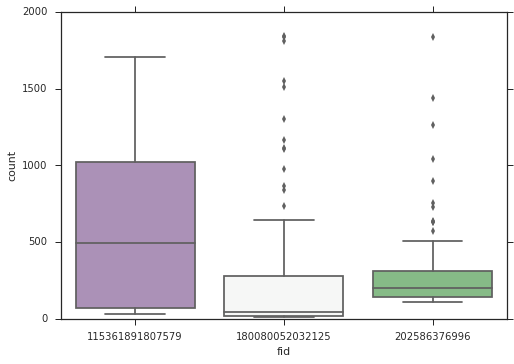

In [4]:
fids = ['202586376996', '180080052032125', '115361891807579']
host = '192.168.1.100:9200'
pngFilePath = "output.png"
outlierFilter = 2000

boxPlotFBFansPageComp(fids, host, pngFilePath, outlierFilter)

## Step 3: Box plot (#post per month for specified page)

In [5]:
import pyes
import json
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt


def boxPlotNumofPostPerMonth(fid, host, lowerbound, upperbound, pngFilePath):
    conn = pyes.es.ES(host)
    tq = pyes.query.TermQuery(field="fid", value=fid)
    #tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg = pyes.aggs.DateHistogramAgg('month', field='created_time', interval='month', sub_aggs=[])
    tagg = pyes.aggs.TermsAgg('pid', field= 'fid_pid')
    DHAgg.sub_aggs.append(tagg) 
    qsearch = pyes.query.Search(tq) 
    qsearch.agg.add(DHAgg) 
    result = conn.search(query=qsearch, indices='facebook_nested', doc_types='comment')

    data=[]
    for r in result.aggs["month"]["buckets"]:
        for pid in r["pid"]["buckets"]:
            monthyear = datetime.datetime.strptime(r["key_as_string"], "%Y-%m-%dT%H:%M:%S.%fZ").strftime('%Y/%m')
            data.append([pid["doc_count"], monthyear, pid["key"], r["key"]])

    df = pd.DataFrame(data, columns={'date', 'count', 'fid', 'pid'})
    sns.set(style="ticks")
    sns_plot = sns.boxplot(x="date", y="count", data=df, palette="PRGn")
    fig = sns_plot.get_figure()
    plt.ylim(lower_bound, upper_bound)
    fig.savefig(pngFilePath)

## Step 4: Please assign several Facebook fan pages and parameters

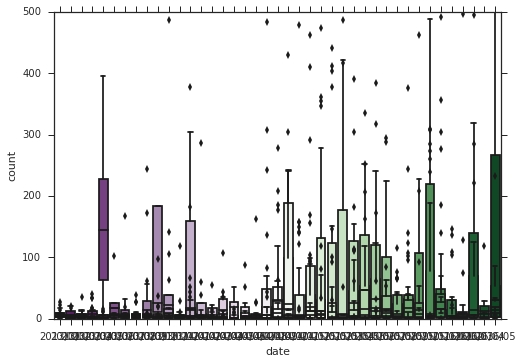

In [9]:
host = '192.168.1.100:9200'
lower_bound = 0
upper_bound = 500

fids = ['202586376996', '180080052032125', '115361891807579']
pngFilePaths = ["output3.png", 'output4.png', 'output5.png']
for fid, path in zip(fids, pngFilePaths):
    boxPlotNumofPostPerMonth(fid, host, lower_bound, upper_bound, pngFilePath)